# MNIST Experiments - Playing With Different Architectures

Sometimes we need to come back to the basis, this is the place I choose for that.

Here I'll experiment with different networks on the MNIST and MNIST variants datasets trying to find relations in which I can reduce the number of parameters in comparison with a Fully Connected (FC) network.

Later on, I might try with other datasets that are small enough for my GTX1080.

Yes, I know, the issue is already solved for Images with Convolutional Networks but what I want to see is not that. Instead I want to understand ways in which fully connected networks can be replaced by other types of connections to minimize the number of parameters in it. This is an exploratory work to get a deeper understanding on Neural Networks (NNs) that will at least give me some fun time.



## Index

#### Datasets to use:
* MNIST
* ... ??? (later might update this)

#### Experiments I intend to run:
- Fully Connected Network
- Convolutional with late FC layer for clasification
- Randomly Connected Network (Sparse)
- Parallel Smaller Fully Connected Networks with a late merge for clasification (several "columns" instead of one big fully connected)
    * Only continuous subsets of elements
    * Playing with reordering the elements in the input
Structurally Connected Networks (Different Structures will be used, is a follow up of the parallel)


#### KPIs I intend to measure:
- Number of Parameters
- Performance ( Accuracy, Errors, ... )
- Training Time
- Evaluation Time

Although training and evaluation time 

#### Things I would like to analyse later:
* Kind of Errors
* 




In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [42]:
import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
# Network modules  to try
from network_modules import *
from net_utils import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:

def transform_mnist():
    return transforms.Compose([
#         transforms.Grayscale(),
#         transforms.Resize((w, h)),  # this should be used ONLY if the image is bigger than this size
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.25)
    ])
# Datasets:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist())


## Fully Connected 

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()


In [36]:
# something like this will be used to create the sparsity masks ... only that the sparsity distributions should be chosen before
torch.bernoulli(torch.rand(10, 14)).expand(10, 14).clone() 


tensor([[0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.],
        [1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1.],
        [1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.],
        [1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.],
        [1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.]])

In [49]:
img0, lbl0 = mnist_trainset[0]

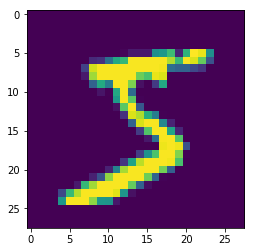

In [56]:
plt.imshow(img0.squeeze())

In [ ]:


def train(model, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):

    model.to(device)
    num_epochs = 100
    batch_size = 128
#     learning_rate = 0.0001
    learning_rate = 0.001
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    transformation = transform_mnist()
    train_loader, test_loader = get_loaders(batch_size, transformation)


    for epoch in range(num_epochs):
        for i, (img, labels) in enumerate(train_loader):
            img = Variable(img).to(device)
            # ===================forward=====================
            #         print("encoding batch of  images")
            output = model(img)
            #         print("computing loss")
            loss = criterion(output, img)
            # ===================backward====================
            #         print("Backward ")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data[0]))
        if epoch % 10 == 0:
            pic = to_img(output.cpu().data)
            in_pic = to_img(img.cpu().data)
            save_image(pic, './cae_results/2x2-out_image_{}.png'.format(epoch))
            save_image(in_pic, './cae_results/2x2-in_image_{}.png'.format(epoch))
        if loss.data[0] < 0.15: #arbitrary number because I saw that it works well enough
            break
    model.save_model("2x2-layer", "CAE")
